- 说明：该程序构造一个**变分自动编码器**

- Reference: [《Auto-Encoding Variational Bayes》](https://arxiv.org/abs/1312.6114)

- 数据集：MNIST

- 时间：2019年6月28日

## 加载keras模块

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

Using TensorFlow backend.


## 变量初始化

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0

## 模型搭建

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    
    # 构造一个正态分布
    epsilon = K.random_normal(
        shape=(batch_size, latent_dim), 
        mean=0.,
        stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [5]:
x = Input(batch_shape=(batch_size, original_dim))  # original_dim=784
h = Dense(intermediate_dim, activation='relu')(x)  # intermediate_dim=25
print(x)
print(h)

z_mean = Dense(latent_dim)(h)  # latent_dim=2
z_log_var = Dense(latent_dim)(h)  # latent_dim=2
print(z_mean)
print(z_log_var)

# note that "output_shape" isn't necessary with the TensorFlow backend
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
z = Lambda(sampling)([z_mean, z_log_var])
print(z)

Instructions for updating:
Colocations handled automatically by placer.
Tensor("input_1:0", shape=(100, 784), dtype=float32)
Tensor("dense_1/Relu:0", shape=(100, 256), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(100, 2), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(100, 2), dtype=float32)
Tensor("lambda_1/add:0", shape=(100, 2), dtype=float32)


In [6]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
print(decoder_h)
print(decoder_mean)

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
print(h_decoded)
print(x_decoded_mean)

Tensor("dense_4/Relu:0", shape=(100, 256), dtype=float32)
Tensor("dense_5/Sigmoid:0", shape=(100, 784), dtype=float32)


In [7]:
def vae_loss(x, x_decoded_mean):
    """
        变分自动编码机的loss由两部分相加得到：
        [1] 交叉熵
        [2] KL散度
    """
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [8]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (100, 784)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (100, 256)           200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (100, 2)             514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (100, 2)             514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## 模型训练

In [9]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [10]:
vae.fit(
    x_train, x_train,
    shuffle=True,
    nb_epoch=nb_epoch,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

Instructions for updating:
Use tf.cast instead.


D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 89us/step - loss: 188.9358 - val_loss: 171.5854
Epoch 2/50
60000/60000 [==============================] - 9s 154us/step - loss: 169.2328 - val_loss: 168.1914
Epoch 3/50
60000/60000 [==============================] - 6s 105us/step - loss: 165.8583 - val_loss: 165.1016
Epoch 4/50
60000/60000 [==============================] - 5s 84us/step - loss: 163.5873 - val_loss: 163.0991
Epoch 5/50
60000/60000 [==============================] - 5s 87us/step - loss: 161.7389 - val_loss: 161.3564
Epoch 6/50
60000/60000 [==============================] - 5s 88us/step - loss: 160.2312 - val_loss: 159.8023
Epoch 7/50
60000/60000 [==============================] - 5s 88us/step - loss: 159.0726 - val_loss: 158.6797
Epoch 8/50
60000/60000 [==============================] - 5s 83us/step - loss: 158.0961 - val_loss: 157.9749
Epoch 9/50
60000/60000 [==============================] - 6s 101us/step - lo

## 编码网络

In [11]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)  # z_mean是输出？

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (100, 784)                0         
_________________________________________________________________
dense_1 (Dense)              (100, 256)                200960    
_________________________________________________________________
dense_2 (Dense)              (100, 2)                  514       
Total params: 201,474
Trainable params: 201,474
Non-trainable params: 0
_________________________________________________________________


## 效果展示

### 分类效果

In [12]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
print(x_test_encoded.shape)

(10000, 2)


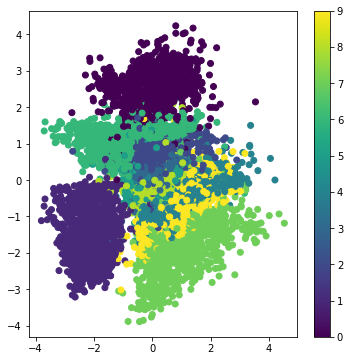

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

### 编码机还原效果

In [15]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))

_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)

In [16]:
generator = Model(decoder_input, _x_decoded_mean)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              multiple                  768       
_________________________________________________________________
dense_5 (Dense)              multiple                  201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


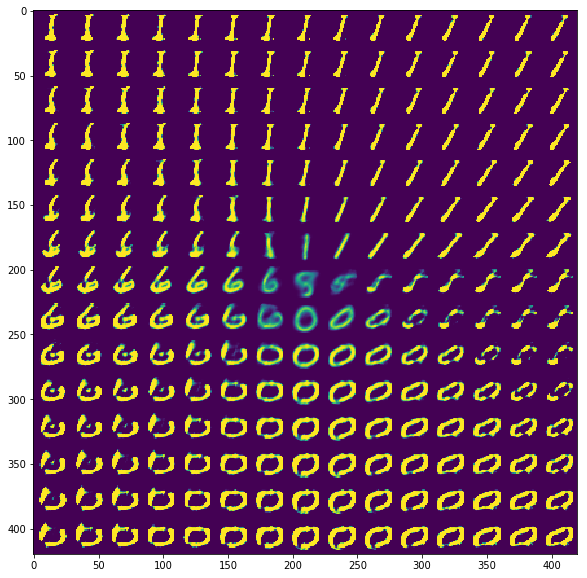

In [22]:
# display a 2D manifold of the digits

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()